In [1]:
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
sys.path.append("/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE")

In [3]:
from scripts.maploader.datamodules import DataModule
from scripts.maploader.fits_dataset import MapDataset
from scripts.utils.params import set_data_params 

In [4]:
params = set_data_params(order=2, difference=False)["data"]
ds = MapDataset(lrdir=params["LR_dir"], hrdir=params["HR_dir"], order=params["order"], difference=False)

params = set_data_params(order=2, difference=True)["data"]
ds_diff = MapDataset(lrdir=params["LR_dir"], hrdir=params["HR_dir"], order=params["order"], difference=True)

n_maps is not specified, loading all maps in the directory.
LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc128.  Number of maps: 100
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc256.  Number of maps: 100
data divided into 48 patches.
n_maps is not specified, loading all maps in the directory.
LR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc128.  Number of maps: 100
HR data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc256.  Number of maps: 100
data divided into 48 patches.


/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/scripts/maploader/data_transformer.py:41: RuntimeWarning: divide by zero encountered in log
  self.transform = lambda t: np.log(t + 1) # [0, inf] -> [0, inf]
/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/scripts/maploader/fits_dataset.py:23: RuntimeWarning: invalid value encountered in subtract
  map_normalized = sigmoid.transform(linear2log.transform(hrmap) - linear2log.transform(lrmap))


In [9]:
import os
os.cpu_count()

80

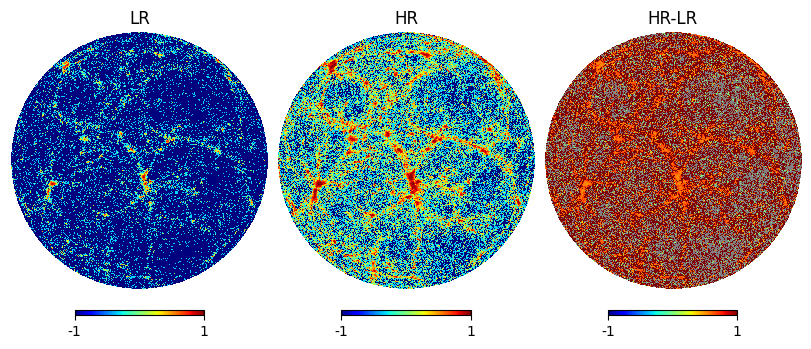

In [13]:
sample_lr = ds[1][0][0,:,0].detach().cpu().numpy()
sample_hr = ds[1][1][0,:,0].detach().cpu().numpy()
sample_diff = ds_diff[1][1][0,:,0].detach().cpu().numpy()


plt.figure(figsize=(8, 4))
hp.orthview(sample_lr, half_sky=True, nest=True, title="LR", cmap="jet", sub=(1, 3, 1), min=-1, max=1)
hp.orthview(sample_hr, half_sky=True, nest=True, title="HR", cmap="jet", sub=(1, 3, 2), min=-1, max=1)
hp.orthview(sample_diff, half_sky=True, nest=True, title="HR-LR", cmap="jet", sub=(1, 3, 3), min=-1, max=1)
plt.show()

In [1]:
dm = DataModule(**params["data"])
dm.setup()

NameError: name 'DataModule' is not defined

In [ ]:
td = dm.dataset

In [4]:
from scripts.maploader.maploader import get_data_from_params, get_normalized_from_params, Transforms
from scripts.utils.params import set_params
from scripts.diffusion.DDPM import linear_beta_schedule, Diffusion

/gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
base_dir = "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE"
params = set_params(base_dir,
        n_maps=1,
        order=2,
        transform_type="sigmoid",
        model="diffusion",
        conditioning="concat",
        norm_type="group",
        act_type="silu",
        block="biggan",
        mask=False,
        use_attn=False,
        scheduler="linear",
        target="HR", 
        batch_size=4)

In [6]:
lr, hr = get_data_from_params(params)
data_input, data_condition, transforms_lr, transforms_hr= get_normalized_from_params(lr, hr, params)

data loaded from //gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc128_smoothed/.  Number of maps: 1
data nside: 512, divided into 48 patches, each patch has 65536 pixels.
data loaded from /gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE/data/nc256_smoothed/.  Number of maps: 1
data nside: 512, divided into 48 patches, each patch has 65536 pixels.
data normalized to [-0.8035985231399536,1.0] by sigmoid transform.
data normalized to [-0.9048800468444824,1.0] by sigmoid transform.


In [31]:
# Calculate the grid area
grid_area = hp.pixelfunc.nside2pixarea(params["data"]["nside"], degrees=True)

# Print the grid area in square degrees
print("Grid area:", grid_area, "square degrees")

Grid area: 0.013113963206424481 square degrees


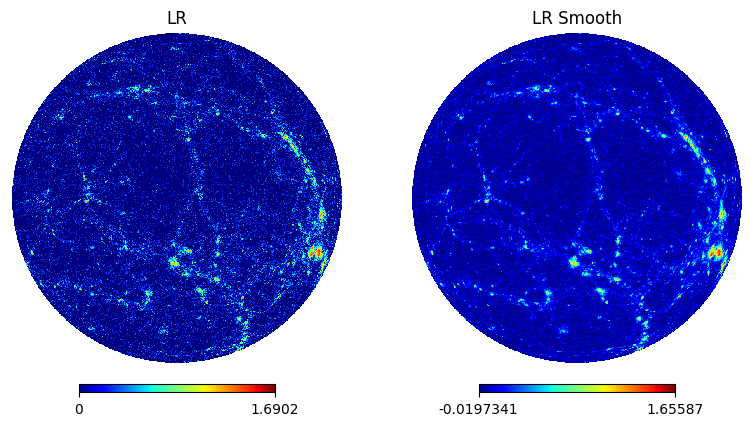

In [24]:
sample = np.hstack(lr[:, :, 0].detach().cpu().numpy())
sample_smooth = hp.smoothing(sample, sigma=np.deg2rad(5./60.), nest=True)

plt.figure(figsize=(8, 4))
hp.orthview(sample, half_sky=True, nest=True, title="LR", cmap="jet", sub=(1, 2, 1))
hp.orthview(sample_smooth, half_sky=True, nest=True, title="LR Smooth", cmap="jet", sub=(1, 2, 2))
plt.show()

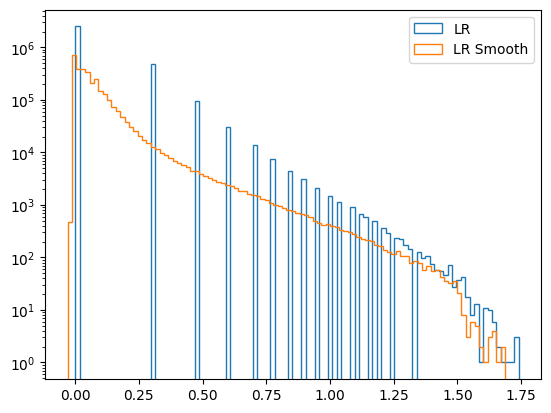

In [29]:
plt.hist(sample.flatten(), bins=100, histtype="step", label="LR")
plt.hist(sample_smooth.flatten(), bins=100,  histtype="step", label="LR Smooth")

plt.legend()
plt.yscale("log")
plt.show()


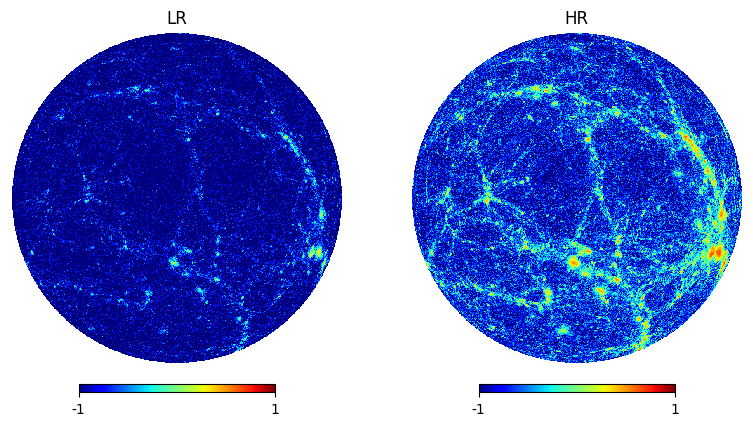

In [23]:
plt.figure(figsize=(8, 4))
hp.orthview(np.hstack(data_condition[:, :, 0].detach().cpu().numpy()), half_sky=True, title="LR", nest=True, cmap="jet", min=-1, max=1, sub=(1, 2, 1))
hp.orthview(np.hstack(data_input[:, :, 0].detach().cpu().numpy()), half_sky=True, title="HR", nest=True, cmap="jet", min=-1, max=1, sub=(1, 2, 2))
plt.show()

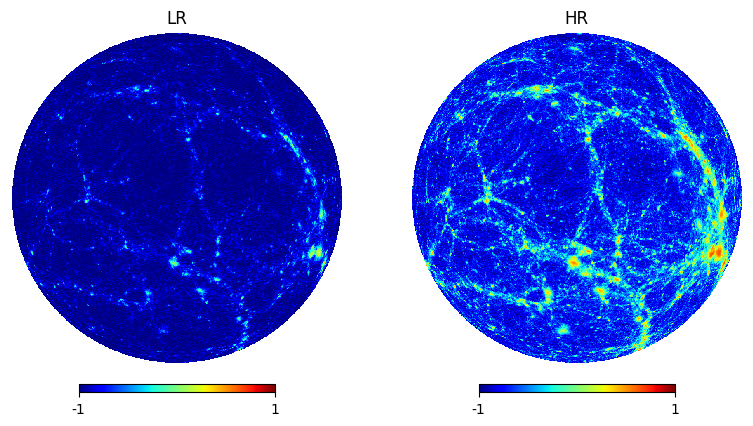

In [26]:
inp_smooth = hp.smoothing(np.hstack(data_input[:, :, 0].detach().cpu().numpy()), sigma=np.deg2rad(5./60.), nest=True)
cond_smooth = hp.smoothing(np.hstack(data_condition[:, :, 0].detach().cpu().numpy()), sigma=np.deg2rad(5./60.), nest=True)

plt.figure(figsize=(8, 4))
hp.orthview(inp_smooth, half_sky=True, title="HR", nest=True, cmap="jet", min=-1, max=1, sub=(1, 2, 2))
hp.orthview(cond_smooth, half_sky=True, title="LR", nest=True, cmap="jet", min=-1, max=1, sub=(1, 2, 1))
plt.show()

<Figure size 400x400 with 0 Axes>

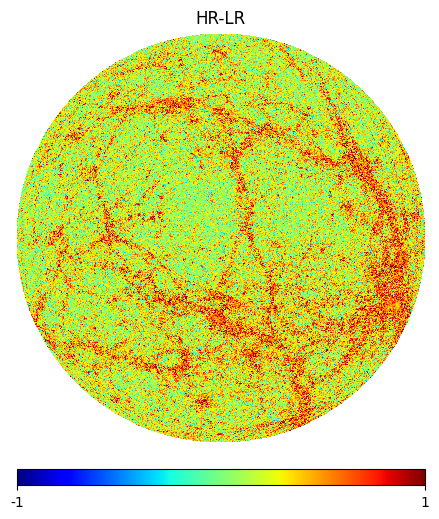

In [25]:
plt.figure(figsize=(4, 4))
hp.orthview(np.hstack((data_input-data_condition)[:, :, 0].detach().cpu().numpy()), half_sky=True, title="HR-LR", nest=True, cmap="jet", min=-1, max=1)
plt.show()

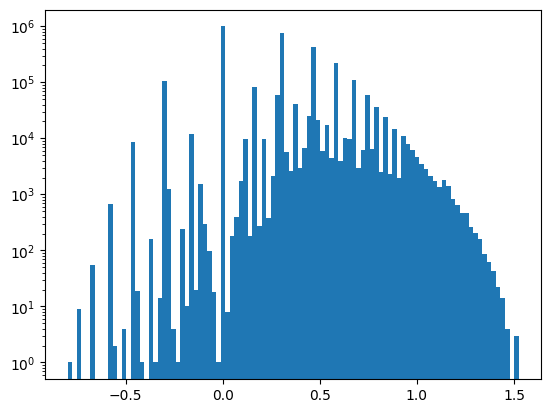

In [27]:
plt.hist((data_input-data_condition).flatten().detach().cpu().numpy(), bins=100)
plt.yscale("log")
plt.show()

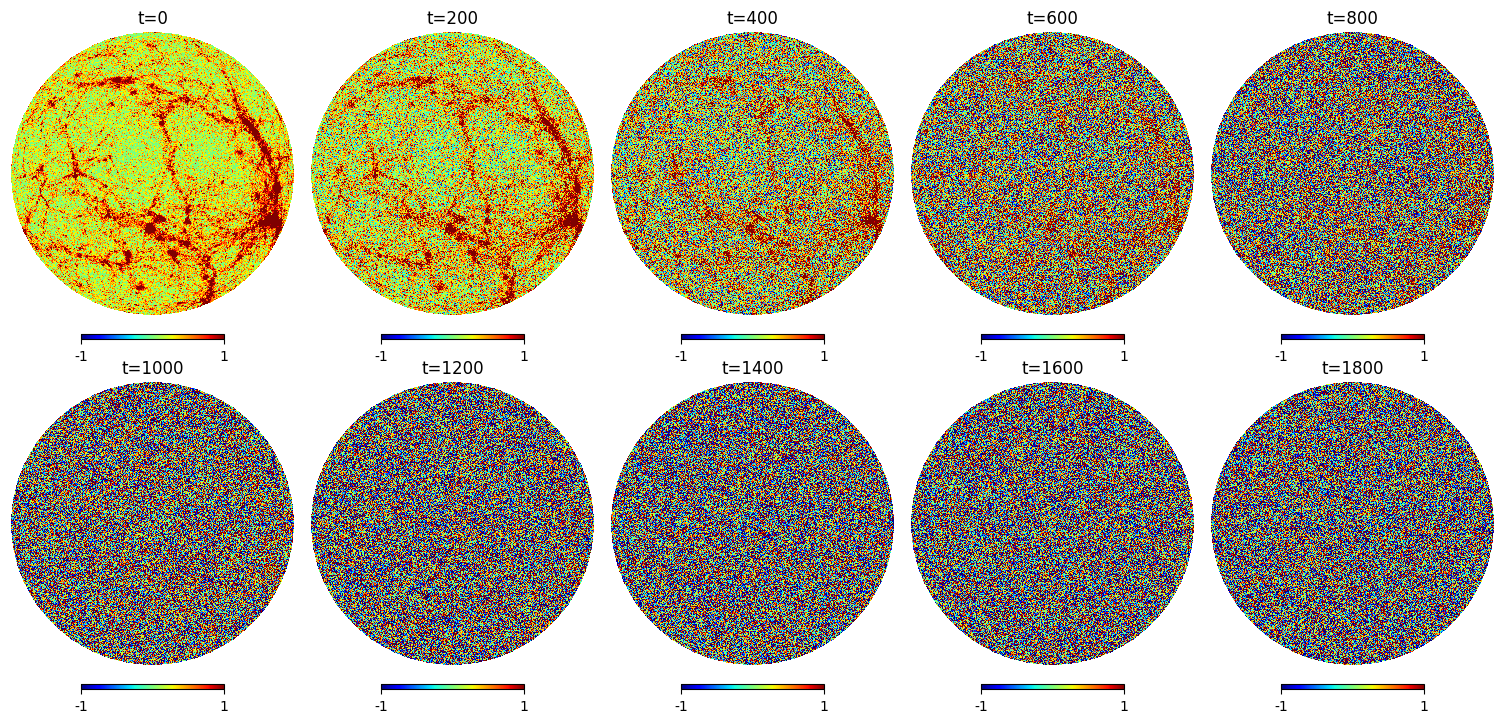

In [8]:
# diffused data
timesteps = int(params['diffusion']['timesteps'])
betas = linear_beta_schedule(timesteps=timesteps, beta_start=params['diffusion']['linear_beta_start'], beta_end=params['diffusion']['linear_beta_end'])
diffusion = Diffusion(betas)
sample_timesteps = [200*i for i in range(timesteps//200)]
tmp_hr = hr[:, :, 0]
fig = plt.figure(figsize=(15, 7))
for i, t in enumerate(sample_timesteps):
    time = torch.full((12*params["data"]["order"]**2,), t, dtype=torch.long)
    tmp_sample = diffusion.q_sample(tmp_hr, time)
    #print("mean {}, var {}".format(tmp_sample.mean(), tmp_sample.var()))
    hp.orthview(np.hstack(tmp_sample.detach().cpu().numpy()), fig=fig, nest=True, title=f"t={t}", sub=(2, 5, i+1), min=-1, max=1, cmap='jet', half_sky=True)

In [20]:
import random
from scripts.utils.diffusion_utils import mask_with_gaussian, extract_masked_region, hr_or_sample

In [26]:
x = data_input[:, :, :]
masks = [[1, 1, 1, 1], [0, 0, 1, 1], [0, 1, 0, 1], [0, 0, 0, 1]]
mask = [random.choice(masks) for _ in range(x.shape[0])]
noise = torch.randn_like(x)
t = torch.randint(200, 1500, (x.shape[0],), device=x.device).long()
x_t = diffusion.q_sample(x_start=x, t=t, noise=noise)

In [27]:
x_masked = torch.cat([hr_or_sample(x[j:j+1, :, :], x_t[j:j+1, :, :], mask[j]) for j in range(x.shape[0])], dim=0)

<Figure size 400x400 with 0 Axes>

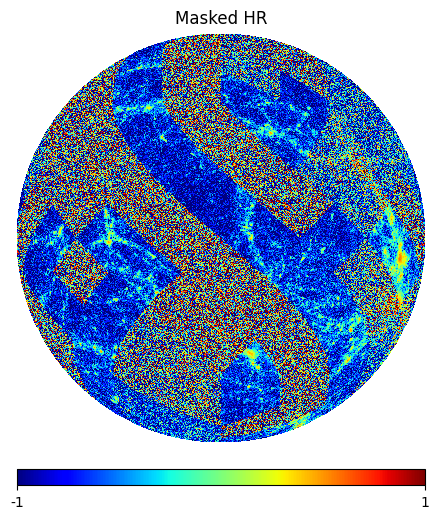

In [28]:
plt.figure(figsize=(4, 4))
hp.orthview(np.hstack(x_masked[:, :, 0].detach().cpu().numpy()), title="Masked HR", half_sky=True, nest=True, min=-1, max=1, cmap="jet")
plt.show()

In [7]:
dat = hp.read_map("/gpfs02/work/akira.tokiwa/gpgpu/data/WLmap_hirosaki/allskymap_nres12r000.zs1.mag.fits")

In [15]:
log2linear = Transforms(transform_type="log2linear")



plt.hist(np.log(dat + 1).flatten(), bins=100)
plt.yscale("log")
plt.show()

NameError: name 'log2linear' is not defined

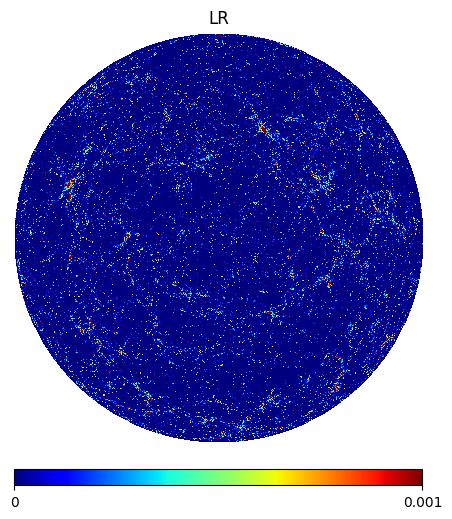

In [10]:
hp.orthview(dat, half_sky=True, title="LR", cmap="jet", min=0, max=0.001)